In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor

In [297]:
test = pd.read_excel('건대+스타벅스.xlsx')

In [298]:
test[['날짜']] = test[['날짜']].fillna(method='ffill')
test['date_time'] = [pd.to_datetime(re.sub(r"[ㄱ-ㅣ가-힣]", "", test['날짜'].values[i]) + str(test['시간'].values[i])) for i in range(test.shape[0])]
test = test.replace('s', 0)


In [300]:


def run_preprocess(df_in):
    df_out = df_in.copy()
    df_out = df_out.iloc[:, 2:]
    df_out.iloc[:,:11] = df_out.iloc[:,:11].astype(np.float64)

    df_out["datetime-year"] = df_out["date_time"].dt.year
    df_out["datetime-month"] = df_out["date_time"].dt.month
    df_out["datetime-day"] = df_out["date_time"].dt.day
    df_out["datetime-hour"] = df_out["date_time"].dt.hour
    df_out["datetime-minute"] = df_out["date_time"].dt.minute
    df_out["datetime-dayofweek"] = df_out["date_time"].dt.dayofweek

    return df_out



In [301]:
val_df = run_preprocess(df_in=test)

In [302]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   a1(30분)             2484 non-null   float64       
 1   a2(1시간)             2484 non-null   float64       
 2   b1(1시간 30분)         2484 non-null   float64       
 3   b2(2시간)             2484 non-null   float64       
 4   c1(2시간 30분)         2484 non-null   float64       
 5   c2(3시간)             2484 non-null   float64       
 6   d1(3시간 30분)         2484 non-null   float64       
 7   d2(4시간)             2483 non-null   float64       
 8   e1(5시간)             2484 non-null   float64       
 9   e2(6시간)             2484 non-null   float64       
 10  e3(7시간)             2482 non-null   float64       
 11  사람이 있는 데이블갯수        2484 non-null   int64         
 12  남은자리수               2484 non-null   int64         
 13  date_time           2484 non-null   datetime64[n

<AxesSubplot:xlabel='datetime-hour', ylabel='남은자리수'>

d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
d:\

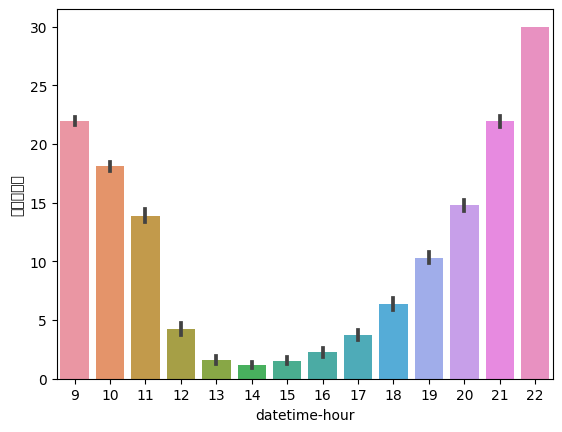

In [303]:
sns.barplot(data=val_df, x="datetime-hour", y="남은자리수")

<AxesSubplot:xlabel='datetime-day', ylabel='남은자리수'>

d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  func(*args, **kwargs)
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
d:\

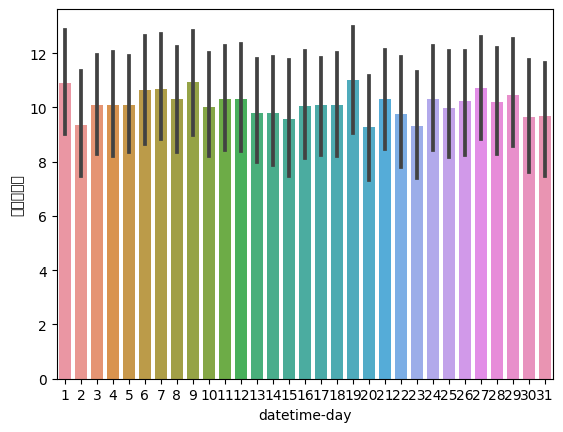

In [304]:
sns.barplot(data=val_df, x="datetime-day", y="남은자리수")

In [305]:

# 시간 데이터에 대한 Cyclic 인코딩 함수
def cyclic_encoding(data, max_value):
    # 사인과 코사인 값을 계산
    sin_values = np.sin(2 * np.pi * data / max_value)
    cos_values = np.cos(2 * np.pi * data / max_value)
    return sin_values, cos_values

def run_cyclic_encoding(df_in):
    df_out = df_in.copy()
    # year 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_year = df_out['datetime-year'].max()
    df_out['year_sin'], df_out['year_cos']= cyclic_encoding(df_out['datetime-year'], max_year)
    df_out.drop('datetime-year', axis=1, inplace=True)

    # month 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_month = 12
    df_out['month_sin'], df_out['month_cos']= cyclic_encoding(df_out['datetime-month'], max_month)
    df_out.drop('datetime-month', axis=1, inplace=True)

    # day 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_day = 31
    df_out['day_sin'], df_out['day_cos']= cyclic_encoding(df_out['datetime-day'], max_day)
    df_out.drop('datetime-day', axis=1, inplace=True)

    # hour 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_hour = 22
    df_out['hour_sin'], df_out['hour_cos']= cyclic_encoding(df_out['datetime-hour'], max_hour)
    df_out.drop('datetime-hour', axis=1, inplace=True)

    max_min = 30
    minute_sin, minute_cos = cyclic_encoding(df_out['datetime-minute'], max_min)
    df_out['minute_sin'], df_out['minute_cos']= cyclic_encoding(df_out['datetime-minute'], max_hour)
    df_out.drop('datetime-minute', axis=1, inplace=True)

    return df_out



In [306]:
pp_df = run_cyclic_encoding(df_in=val_df)

In [307]:
display(pp_df.head())

a1(30분)  a2(1시간)  b1(1시간 30분)  b2(2시간)  c1(2시간 30분)  c2(3시간)  d1(3시간 30분)  \
0      3.0      2.0          5.0      1.0          2.0      0.0          0.0   
1      1.0      2.0          5.0      1.0          2.0      0.0          0.0   
2      2.0      1.0          5.0      1.0          2.0      0.0          0.0   
3      5.0      1.0          5.0      1.0          2.0      0.0          0.0   
4      2.0      2.0          3.0      1.0          2.0      0.0          0.0   

   d2(4시간)  e1(5시간)  e2(6시간)  ...      year_sin  year_cos  month_sin  \
0      0.0      0.0      0.0  ... -2.449294e-16       1.0  -0.866025   
1      0.0      0.0      0.0  ... -2.449294e-16       1.0  -0.866025   
2      0.0      0.0      0.0  ... -2.449294e-16       1.0  -0.866025   
3      0.0      0.0      0.0  ... -2.449294e-16       1.0  -0.866025   
4      0.0      0.0      0.0  ... -2.449294e-16       1.0  -0.866025   

  month_cos   day_sin  day_cos      hour_sin  hour_cos  minute_sin  minute_cos  
0      -0.5  0.201299  0.97953  5.406408e-01 -0.841254     0.00000    1.000000  
1      -0.5  0.201299  0.97953  5.406408e-01 -0.841254     0.75575   -0.654861  
2      -0.5  0.201299  0.97953  2.817326e-01 -0.959493     0.00000    1.000000  
3      -0.5  0.201299  0.97953  2.817326e-01 -0.959493     0.75575   -0.654861  
4      -0.5  0.201299  0.97953  5.665539e-16 -1.000000     0.00000    1.000000  

[5 rows x 25 columns]

In [308]:

def get_indices_entire_sequence(
        data: pd.DataFrame,
        window_size: int,
        step_size: int
) -> list:
    stop_position = len(data) - 1  # 1- because of 0 indexing

    # Start the first sub-sequence at index position 0
    subseq_first_idx = 0

    subseq_last_idx = window_size

    indices = []

    while subseq_last_idx <= stop_position:
        indices.append((subseq_first_idx, subseq_last_idx))

        subseq_first_idx += step_size

        subseq_last_idx += step_size

    return indices

def get_xgboost_x_y(
        indices: list,
        data: np.array,
        target_sequence_length,
        input_seq_len: int
):
    print("Preparing data..")

    # Loop over list of training indices
    for i, idx in enumerate(indices):
        # Slice data into instance of length input length + target length
        x = data[idx[0]:idx[1], :]

        assert len(x) == input_seq_len

        y = data[idx[1] + target_sequence_length - 1, -1]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:
            all_y = y.reshape(1, -1)
            all_x = x.reshape(1, -1)
        else:
            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)
            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")
    return all_x, all_y



    

In [309]:
train_ratio = 0.8

train_df = pp_df.iloc[:int(pp_df.shape[0]*train_ratio), :]
test_df = pp_df.iloc[int(pp_df.shape[0]*train_ratio):, :]

train_date, test_date = train_df['date_time'], test_df['date_time']

train_df.drop('date_time', axis=1, inplace=True)
test_df.drop('date_time', axis=1, inplace=True)

d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [310]:
label = '남은자리수'
train_x, train_y = train_df.drop(label, axis=1), train_df[[label]].reset_index(drop=True)
test_x, test_y = test_df.drop(label, axis=1), test_df[[label]].reset_index(drop=True)
cols = train_x.columns

In [311]:
scaler = MinMaxScaler()

scaler.fit(train_x)

train_vals = scaler.transform(train_x)
test_vals = scaler.transform(test_x)

train_x = pd.concat([pd.DataFrame(train_vals, columns=cols), train_y],axis=1)
test_x = pd.concat([pd.DataFrame(test_vals, columns=cols),test_y], axis=1)


In [312]:
normed_train_data = train_x.values
normed_test_data = test_x.values 
seq_length = 3

indices_tr = get_indices_entire_sequence(data=train_x, window_size=seq_length, step_size=1) # data에 따른 train index 생성
indices_te = get_indices_entire_sequence(data=test_x, window_size=seq_length, step_size=1) # data에 따른 test index 생성

xg_train_x, xg_train_y= get_xgboost_x_y(indices=indices_tr, data=normed_train_data, target_sequence_length=1, input_seq_len=seq_length) # index에 따른 train data 생성
xg_test_x, xg_test_y= get_xgboost_x_y(indices=indices_te, data=normed_test_data, target_sequence_length=1, input_seq_len=seq_length) # index에 따른 test data 생성
print(normed_test_data.shape)

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
(497, 24)


In [313]:
train_test_dict = {}
train_test_dict['train_x'],train_test_dict['train_y'], train_test_dict['test_x'],train_test_dict['test_y'] = xg_train_x,xg_train_y,xg_test_x,xg_test_y


In [314]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def xgb(params=None):
        
    xgb_model = XGBRegressor(**params) if params is not None else XGBRegressor() # parameter 수정 된 파라미터가 있을 시 해당 parameter 적용, 아니면 그냥 기본 모델 적용

    return xgb_model


def run_xgb(data_dict):
    '''
        Xgboost regressor Model 을 run 하기 위한 함수,
        Input 은 data_dict 로 train, test, std, mean, EPOCHS 등 의 정보를 담고 있다.

        Output 은 pandas series 형식 으로 xgb mse와, numpy array 형식으로 학습된 Model의 test data 예측 값이 출력됨.

        GridCV로 파라미터 최적화 과정이 코드 내 구성 되어 있지만, 시간이 너무 오래걸려서 일단 막아 두었음.
    '''
    result_df = pd.DataFrame()

    train_x, train_y, test_x, test_y = data_dict['train_x'],data_dict['train_y'], data_dict['test_x'],data_dict['test_y']
    # xgb_params = {
    #       'max_depth': [2, 4, 6],
    #       'n_estimators': [100, 500, 1000],
    #       'colsample_bytree': [0.2, 0.6, 0.8],
    #       'min_child_weight': [3, 5, 7],
    #       'gamma': [0.3, 0.5, 0.7],
    #       'subsample': [0.4, 0.6, 0.8]
    #       }
    # gridcv = GridSearchCV(xgb(), param_grid=xgb_params, cv=5)
    #
    # gridcv.fit(train_x, train_y)
    # print(gridcv.best_params_)

    set_params = {'colsample_bytree': 0.2,
                  'gamma': 0.3,
                  'max_depth': 2,
                  'min_child_weight': 3,
                  'n_estimators': 100,
                  'subsample': 0.4}
    model_xgb = xgb(set_params).fit(train_x, train_y)

    # model_xgb = MultiOutputRegressor(xgb(gridcv.best_params_)).fit(train_x, train_y)

    # test data 예측 및 mse loss 계산
    normed_test_predictions = model_xgb.predict(test_x)
    zeros = np.where(normed_test_predictions<0)[0]
    normed_test_predictions[zeros] = 0
    normed_test_predictions = normed_test_predictions.astype(np.int32)

    print('xgb mse : ', np.mean(np.square(normed_test_predictions-test_y.reshape(-1))))
    print('xgb r2 : ', r2_score(test_y.reshape(-1), normed_test_predictions))
    #결과 data frame에 해당 loss 값 할당
    result_df['xgboost_mse'] = pd.Series(np.mean(np.square(normed_test_predictions-test_y.reshape(-1,1))))
    result_df['xgboost_r2'] = pd.Series(r2_score(test_y.reshape(-1,1), normed_test_predictions))

    return model_xgb, normed_test_predictions.reshape(-1)


In [315]:
model, pred_y = run_xgb(data_dict=train_test_dict)

xgb mse :  5.825910931174089
xgb r2 :  0.9294835291923038


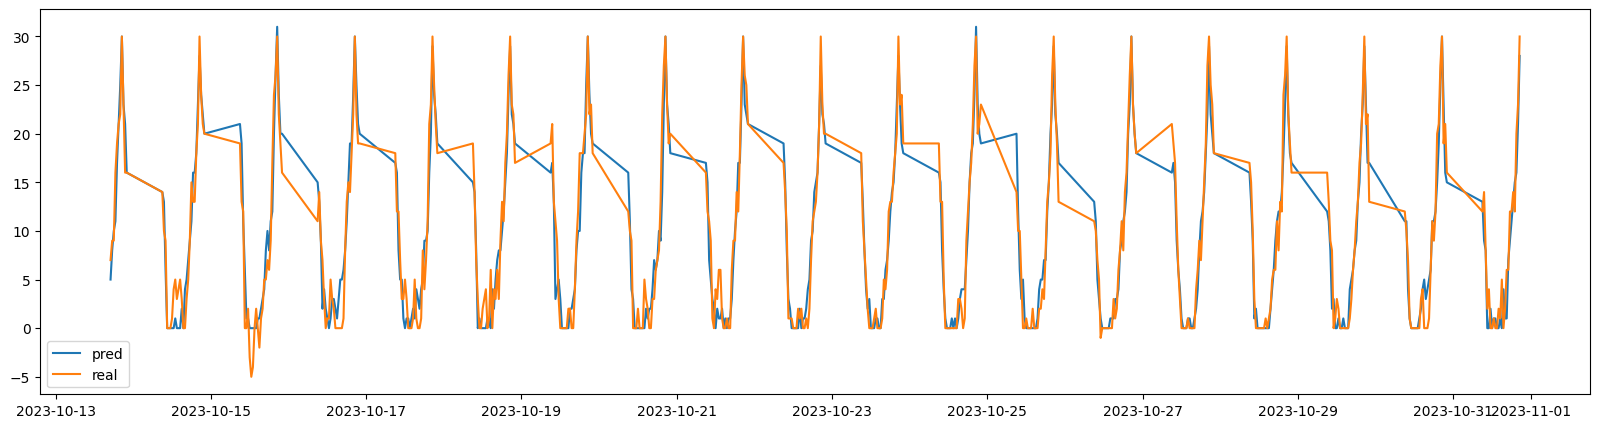

In [316]:
plt.figure(figsize=(20,5))
plt.plot(test_date[:-3], pred_y,label='pred')
plt.plot(test_date[:-3], xg_test_y, label='real')

plt.legend(loc='best')

In [317]:
prd_y = model.predict(test_x[-3:].values.reshape(1, -1))
zeros = np.where(prd_y<0)[0]
prd_y[zeros] = 0
prd_y = prd_y.astype(np.int32)
prd_y

array([22])

In [318]:

# 11월 한 달간의 날짜 범위 설정
start_date = "2023-11-01 09:00:00"
end_date = "2023-11-30 22:00:00"

# 30분 간격으로 시간 데이터 생성
time_data = pd.date_range(start=start_date, end=end_date, freq='30min')

# 오전 9시부터 오후 10시 사이의 시간만 필터링
filtered_time_data = time_data[(time_data.hour >= 9) & (time_data.hour <= 22)]

# 결과 확인
filtered_time_data 


DatetimeIndex(['2023-11-01 09:00:00', '2023-11-01 09:30:00',
               '2023-11-01 10:00:00', '2023-11-01 10:30:00',
               '2023-11-01 11:00:00', '2023-11-01 11:30:00',
               '2023-11-01 12:00:00', '2023-11-01 12:30:00',
               '2023-11-01 13:00:00', '2023-11-01 13:30:00',
               ...
               '2023-11-30 17:30:00', '2023-11-30 18:00:00',
               '2023-11-30 18:30:00', '2023-11-30 19:00:00',
               '2023-11-30 19:30:00', '2023-11-30 20:00:00',
               '2023-11-30 20:30:00', '2023-11-30 21:00:00',
               '2023-11-30 21:30:00', '2023-11-30 22:00:00'],
              dtype='datetime64[ns]', length=839, freq=None)

In [319]:
tabel_num = val_df[['사람이 있는 데이블갯수', '남은자리수']].iloc[0, :].sum()

In [320]:

real_target = pd.DataFrame([np.round(val_df.iloc[i::27, :11].mean(axis=0).values,0) for i in range(0,27)], columns=val_df.columns[:11])

real_target['사람이 있는 데이블갯수'] = real_target.sum(axis=1).astype(np.int64)
real_target['남은자리수'] = tabel_num - real_target['사람이 있는 데이블갯수'] 
real_target['date_time'] = filtered_time_data[:27]
real_target

a1(30분)  a2(1시간)  b1(1시간 30분)  b2(2시간)  c1(2시간 30분)  c2(3시간)  d1(3시간 30분)  \
0       2.0      1.0          1.0      1.0          1.0      0.0          0.0   
1       2.0      2.0          2.0      2.0          1.0      0.0          0.0   
2       4.0      2.0          2.0      2.0          2.0      0.0          0.0   
3       3.0      2.0          2.0      2.0          2.0      0.0          0.0   
4       4.0      2.0          2.0      2.0          2.0      1.0          0.0   
5       6.0      2.0          2.0      2.0          2.0      1.0          0.0   
6      11.0      2.0          2.0      2.0          2.0      1.0          1.0   
7      12.0      2.0          2.0      2.0          3.0      1.0          1.0   
8      12.0      2.0          2.0      2.0          3.0      1.0          1.0   
9      12.0      2.0          2.0      2.0          3.0      1.0          1.0   
10     12.0      2.0          2.0      2.0          3.0      1.0          2.0   
11     11.0      2.0          2.0      2.0          3.0      1.0          2.0   
12     11.0      2.0          2.0      2.0          4.0      1.0          2.0   
13     11.0      2.0          2.0      2.0          4.0      1.0          2.0   
14     11.0      2.0          2.0      2.0          4.0      1.0          1.0   
15     11.0      2.0          2.0      3.0          4.0      1.0          1.0   
16     11.0      2.0          2.0      3.0          4.0      1.0          1.0   
17     11.0      2.0          2.0      3.0          4.0      1.0          1.0   
18     11.0      2.0          2.0      3.0          3.0      1.0          0.0   
19     11.0      2.0          2.0      3.0          3.0      0.0          0.0   
20     10.0      2.0          2.0      2.0          2.0      0.0          0.0   
21     10.0      2.0          1.0      2.0          2.0      0.0          0.0   
22      8.0      2.0          2.0      2.0          2.0      0.0          0.0   
23      6.0      2.0          2.0      2.0          2.0      0.0          0.0   
24      4.0      1.0          1.0      2.0          1.0      0.0          0.0   
25      2.0      1.0          1.0      1.0          1.0      0.0          0.0   
26      0.0      0.0          0.0      0.0          0.0      0.0          0.0   

    d2(4시간)  e1(5시간)  e2(6시간)  e3(7시간)  사람이 있는 데이블갯수  남은자리수  \
0       0.0      0.0      0.0      0.0             6     24   
1       0.0      0.0      0.0      0.0             9     21   
2       0.0      0.0      0.0      0.0            12     18   
3       0.0      0.0      0.0      0.0            11     19   
4       0.0      1.0      0.0      1.0            15     15   
5       1.0      1.0      1.0      1.0            19     11   
6       1.0      1.0      1.0      1.0            25      5   
7       1.0      1.0      1.0      1.0            27      3   
8       1.0      1.0      1.0      1.0            27      3   
9       1.0      1.0      1.0      1.0            27      3   
10      1.0      1.0      1.0      1.0            28      2   
11      2.0      1.0      1.0      1.0            28      2   
12      2.0      1.0      1.0      1.0            29      1   
13      2.0      1.0      1.0      1.0            29      1   
14      2.0      1.0      1.0      1.0            28      2   
15      2.0      1.0      1.0      1.0            29      1   
16      1.0      0.0      1.0      1.0            27      3   
17      1.0      0.0      1.0      1.0            27      3   
18      1.0      0.0      0.0      1.0            24      6   
19      1.0      0.0      0.0      0.0            22      8   
20      1.0      0.0      0.0      0.0            19     11   
21      0.0      0.0      0.0      0.0            17     13   
22      0.0      0.0      0.0      0.0            16     14   
23      0.0      0.0      0.0      0.0            14     16   
24      0.0      0.0      0.0      0.0             9     21   
25      0.0      0.0      0.0      0.0             6     24   
26      0.0      0.0      0.0     

In [ ]:
real_target = run_preprocess(df_in=real_target)


In [205]:
val_df.iloc[26::27, :]

a1(30분)  a2(1시간)  b1(1시간 30분)  b2(2시간)  c1(2시간 30분)  c2(3시간)  \
26          0        0            0        0            0        0   
53          0        0            0        0            0        0   
80          0        0            0        0            0        0   
107         0        0            0        0            0        0   
134         0        0            0        0            0        0   
...       ...      ...          ...      ...          ...      ...   
2375        0        0            0        0            0        0   
2402        0        0            0        0            0        0   
2429        0        0            0        0            0        0   
2456        0        0            0        0            0        0   
2483        0        0            0        0            0        0   

      d1(3시간 30분)  d2(4시간)  e1(5시간)  e2(6시간)  e3(7시간)  사람이 있는 데이블갯수  남은자리수  \
26              0      0.0        0        0      0.0             0     40   
53              0      0.0        0        0      0.0             0     40   
80              0      0.0        0        0      0.0             0     40   
107             0      0.0        0        0      0.0             0     40   
134             0      0.0        0        0      0.0             0     40   
...           ...      ...      ...      ...      ...           ...    ...   
2375            0      0.0        0        0      0.0             0     40   
2402            0      0.0        0        0      0.0             0     40   
2429            0      0.0        0        0      0.0             0     40   
2456            0      0.0        0        0      0.0             0     40   
2483            0      0.0        0        0      0.0             0     40   

               date_time  datetime-year  datetime-month  datetime-day  \
26   2023-08-01 22:00:00           2023               8             1   
53   2023-08-02 22:00:00           2023               8             2   
80   2023-08-03 22:00:00           2023               8             3   
107  2023-08-04 22:00:00           2023               8             4   
134  2023-08-05 22:00:00           2023               8             5   
...                  ...            ...             ...           ...   
2375 2023-10-27 22:00:00           2023              10            27   
2402 2023-10-28 22:00:00           2023              10            28   
2429 2023-10-29 22:00:00           2023              10            29   
2456 2023-10-30 22:00:00           2023              10            30   
2483 2023-10-31 22:00:00           2023              10            31   

      datetime-hour  datetime-minute  datetime-dayofweek  
26               22                0                   1  
53               22                0                   2  
80               22                0                   3  
107              22                0                   4  
134              22                0                   5  
...             ...              ...                 ...  
2375             22                0                   4  
2402             22                0                   5  
2429             22                0                   6  
2456             22                0                   0  
2483             22                0                   1  

[92 rows x 20 columns]